# Grid Setup and Helper Functions

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Define grid size and parameters
GRID_SIZE = 100
ACTIONS = ['UP', 'DOWN', 'LEFT', 'RIGHT']
start = (0, 0)
goal = (99, 99)
obstacles = {(random.randint(0, GRID_SIZE-1), random.randint(0, GRID_SIZE-1)) for _ in range(int(GRID_SIZE*1.5))}

# Display initial setup information
print(f"Grid size: {GRID_SIZE}x{GRID_SIZE}")
print(f"Start position: {start}")
print(f"Goal position: {goal}")
print(f"Number of obstacles: {len(obstacles)}")


Grid size: 100x100
Start position: (0, 0)
Goal position: (99, 99)
Number of obstacles: 148


# Reward Function

In [ ]:
# Define reward function
def reward(state):
    if state == goal:
        return 1.0
    elif state in obstacles:
        return -1.0
    else:
        return -0.04  # Small negative reward to encourage reaching the goal faster


# State Transition Function

In [ ]:
# Define state transition function
def get_next_state(state, action):
    x, y = state
    if action == 'UP' and x > 0:
        x -= 1
    elif action == 'DOWN' and x < GRID_SIZE - 1:
        x += 1
    elif action == 'LEFT' and y > 0:
        y -= 1
    elif action == 'RIGHT' and y < GRID_SIZE - 1:
        y += 1
    return (x, y)


# Value Iteration

In [ ]:
# Value Iteration
def value_iteration(gamma=0.99, threshold=0.01):
    value_function = np.zeros((GRID_SIZE, GRID_SIZE))
    while True:
        delta = 0
        for x in range(GRID_SIZE):
            for y in range(GRID_SIZE):
                state = (x, y)
                if state == goal or state in obstacles:
                    continue
                v = value_function[x, y]
                value_function[x, y] = max([
                    reward(state) + gamma * value_function[get_next_state(state, action)]
                    for action in ACTIONS
                ])
                delta = max(delta, abs(v - value_function[x, y]))
        if delta < threshold:
            break
    return value_function


# Q-Learning

In [ ]:
# Q-Learning
def q_learning(episodes=10000, alpha=0.1, gamma=0.99, epsilon=0.1):
    q_values = np.zeros((GRID_SIZE, GRID_SIZE, len(ACTIONS)))
    for _ in range(episodes):
        state = start
        while state != goal:
            action_idx = (
                np.random.randint(len(ACTIONS)) if random.uniform(0, 1) < epsilon
                else np.argmax(q_values[state[0], state[1]])
            )
            action = ACTIONS[action_idx]
            next_state = get_next_state(state, action)
            reward_val = reward(next_state)
            best_next_action = np.argmax(q_values[next_state[0], next_state[1]])
            q_values[state[0], state[1], action_idx] += alpha * (
                reward_val + gamma * q_values[next_state[0], next_state[1], best_next_action]
                - q_values[state[0], state[1], action_idx]
            )
            state = next_state
    policy = {(x, y): ACTIONS[np.argmax(q_values[x, y])]
              for x in range(GRID_SIZE)
              for y in range(GRID_SIZE)
              if (x, y) not in obstacles and (x, y) != goal}
    return policy


# Visualization

In [ ]:
# Visualization
def visualize_policy(policy):
    grid = np.zeros((GRID_SIZE, GRID_SIZE))
    for obstacle in obstacles:
        grid[obstacle] = -1
    grid[start] = 0.5
    grid[goal] = 1
    for (x, y), action in policy.items():
        if (x, y) == goal or (x, y) in obstacles:
            continue
        if action == 'UP':
            grid[x, y] = 0.2
        elif action == 'DOWN':
            grid[x, y] = 0.4
        elif action == 'LEFT':
            grid[x, y] = 0.6
        elif action == 'RIGHT':
            grid[x, y] = 0.8
    plt.imshow(grid, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.show()


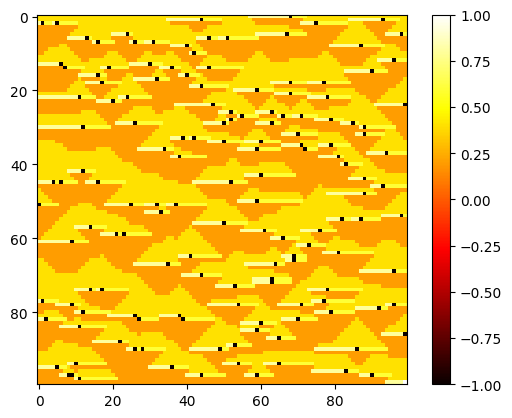

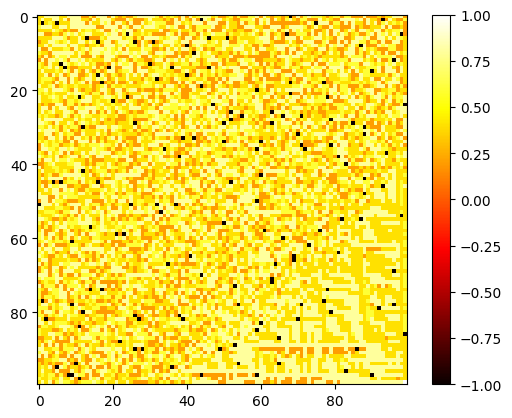

In [ ]:
# Running the algorithms and displaying policies
value_func = value_iteration()
value_policy = {(x, y): ACTIONS[np.argmax([value_func[get_next_state((x, y), action)] for action in ACTIONS])]
                for x in range(GRID_SIZE) for y in range(GRID_SIZE) if (x, y) not in obstacles and (x, y) != goal}
visualize_policy(value_policy)

q_policy = q_learning()
visualize_policy(q_policy)


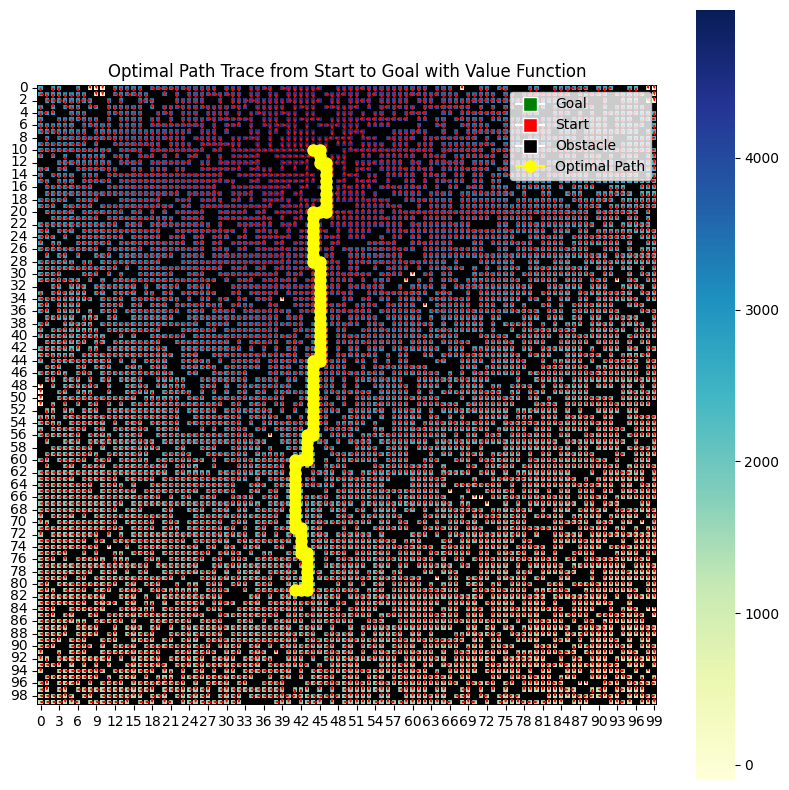

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def find_optimal_path(start, goal, policy):
    """Trace the optimal path from start to goal using the given policy."""
    path = [start]
    current_state = start

    while current_state != goal:
        if current_state in policy:
            # Get the optimal action from the policy
            action = policy[current_state]
            next_state = get_next_state(current_state, action)
            path.append(next_state)
            current_state = next_state
        else:
            # No policy defined (such as an obstacle or out of bounds), exit to prevent infinite loop
            break

    return path

def visualize_optimal_path_with_trace(value_function, policy, start, goal, obstacles):
    """Visualize the grid with the value function, optimal path arrows, and optimal path trace."""

    # Find the optimal path based on the policy
    optimal_path = find_optimal_path(start, goal, policy)

    # Set up plot
    plt.figure(figsize=(10, 10))
    sns.heatmap(
        value_function,
        annot=False,
        cmap="YlGnBu",
        cbar=True,
        square=True,
        linewidths=0.1,
        linecolor="black"
    )

    # Add arrows for the optimal policy
    for (x, y), action in policy.items():
        if (x, y) != goal and (x, y) not in obstacles:
            dx, dy = ACTIONS[action]
            plt.arrow(
                y + 0.5, x + 0.5, dy * 0.3, dx * 0.3,
                head_width=0.2, head_length=0.2, fc='red', ec='red'
            )

    # Plot the optimal path with circles
    for (x, y) in optimal_path:
        plt.plot(y + 0.5, x + 0.5, 'o', color='yellow', markersize=8)

    # Mark obstacles with black
    for (x, y) in obstacles:
        plt.gca().add_patch(plt.Rectangle((y, x), 1, 1, color="black"))

    # Mark the goal with green
    plt.gca().add_patch(plt.Rectangle((goal[1], goal[0]), 1, 1, color="green", label="Goal"))

    # Mark the start with red
    plt.gca().add_patch(plt.Rectangle((start[1], start[0]), 1, 1, color="red", label="Start"))

    # Display plot title and legend
    plt.title("Optimal Path Trace from Start to Goal with Value Function")
    plt.legend(handles=[
        plt.Line2D([0], [0], marker='s', color='w', markerfacecolor="green", markersize=10, label="Goal"),
        plt.Line2D([0], [0], marker='s', color='w', markerfacecolor="red", markersize=10, label="Start"),
        plt.Line2D([0], [0], marker='s', color='w', markerfacecolor="black", markersize=10, label="Obstacle"),
        plt.Line2D([0], [0], marker='o', color='yellow', label="Optimal Path", markersize=8)
    ], loc="upper right")

    plt.show()

# Run visualization with trace
visualize_optimal_path_with_trace(value_function, policy_vi, start, goal, obstacles)
